In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

prices = pd.read_excel('data/generated_average_prices.xlsx')
precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

According to 'The Demand for Expert Opinion: Bordeaux Wine', some important factors are:
- Age of Wine
- Average temperature in the summer (Apr-Sep)
- Harvest rain (Aug-Sep)
- Winter rain (Oct-Mar)

We are going to try and recreate the results of the regression that was run in the paper.

# Feature engineering - recreating the Ashenfelter experiment

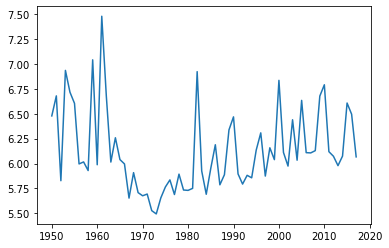

In [3]:
y = prices.set_index('Vintage', drop=True)
y['Log Price'] = np.log(y['Price'])
y=y[['Log Price']]
sns.lineplot(data=y['Log Price'])
plt.show()

In [4]:
X = pd.DataFrame(index = precipitations.index)
X['Harvest Rain'] = precipitations['Aou'] + precipitations['Sep']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Summer Temperature'] = (temp_maximals['Avr'] + temp_maximals['Mai'] + temp_maximals['Jui'] + temp_maximals['Juil']\
+ temp_maximals['Aou'] + temp_maximals['Sep'] + temp_minimals['Avr'] + temp_minimals['Mai'] + temp_minimals['Jui'] + temp_minimals['Juil']\
+ temp_minimals['Aou'] + temp_minimals['Sep']) / 12

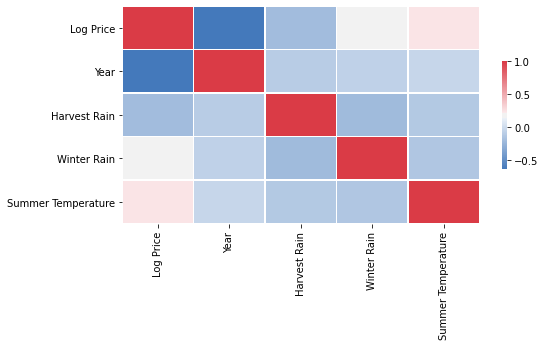

In [5]:
oldest_vintage=1950
newest_vintage=1980
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)
corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

## Building the model

In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(normalize=False)
oldest_vintage=1950
newest_vintage=1980

y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
model.fit(X_ex, y_ex)
for i in range(len(X_ex.columns.to_list())):  
    print(X_ex.columns.to_list()[i], model.coef_[i])
print('Model Score: ',model.score(X_ex,y_ex))

Year -0.03395578596174775
Harvest Rain -0.001576195775434065
Winter Rain 0.0005314719412488751
Summer Temperature 0.15401958899121196
Model Score:  0.536693747082325


This score is quite good, but not as impressive as in the first experiment. This could be due to several factors: the prices were not gathered the same way, the corpus of wines is different, the prices have changed since the experiment. Let us now try to see how this modelss result have changed over time.

In [7]:
from sklearn.preprocessing import StandardScaler

def model_tester(X, y):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1985))
    scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for column in coefficients:
        oldest_vintage = column
        newest_vintage = column + 30

        y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()

        model.fit(X_ex,y_ex)
        coefs = pd.Series(model.coef_)
        coefs.index = coefficients.index
        coefficients[column] = coefs
        scores.append(model.score(X_ex,y_ex))
    
    coefficients = coefficients.transpose()
    display(coefficients.head())
    return coefficients, scores


#We will need ticks correspoding to our rolling windows for the graphs
labels = [str(i)+'-'+str(i+30) for i in range(1950,1986,5)]

,Year,Harvest Rain,Winter Rain,Summer Temperature
1950,-0.033956,-0.107558,0.071454,0.170213
1951,-0.029186,-0.076326,0.136328,0.278822
1952,-0.029321,-0.079133,0.124570,0.269262
1953,-0.034674,-0.065931,0.143025,0.321549
1954,-0.033499,-0.066557,0.140127,0.319004


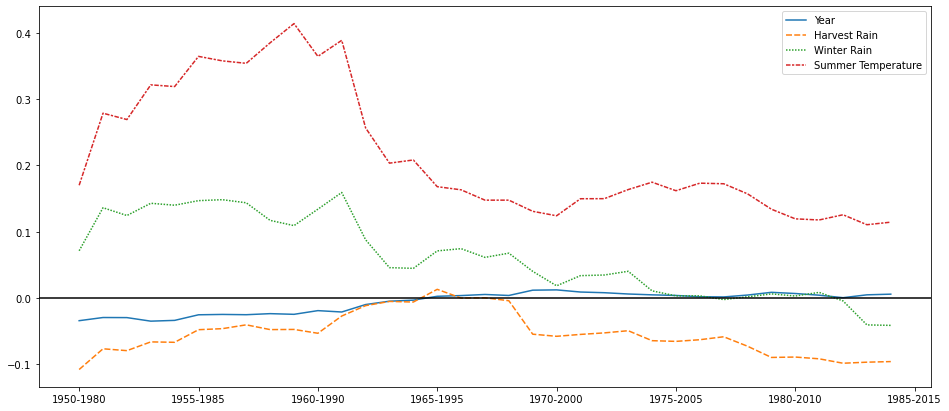

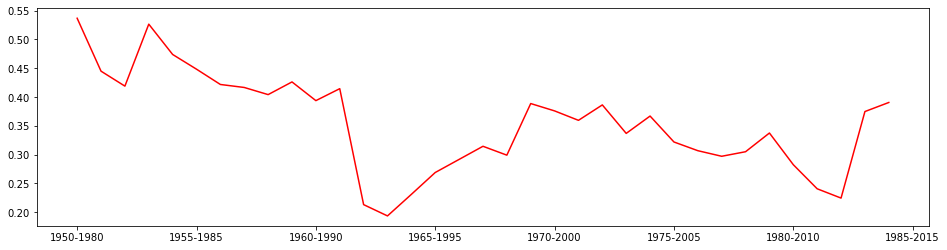

Average score over the whole period:  0.3552877125551304


In [8]:
coefficients, scores = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,36,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

# Adding new variables

In [9]:
X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] = precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou'] + precipitations['Sep']
X['Spring Rain'] = precipitations['Mar']+precipitations['Avr']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Insulation'] = insulation.iloc[:,0]

X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])+\
    (temp_maximals['Mar'] + temp_minimals['Mar'])
X['Early Summer Temperature'] = \
    (temp_maximals['Avr'] + temp_minimals['Avr']) +\
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui']) +\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Late Summer Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])

X['Frost Days Winter'] = frost_days.shift(1)['Nov']+frost_days.shift(1)['Dec'] + frost_days['Jan']
X['Frost Days Early'] = frost_days['Fev']+frost_days['Mar']
X['Frost Days Late'] = frost_days['Avr']+ 2*(frost_days['Mai'] + frost_days['Jui'] + frost_days['Juil'])

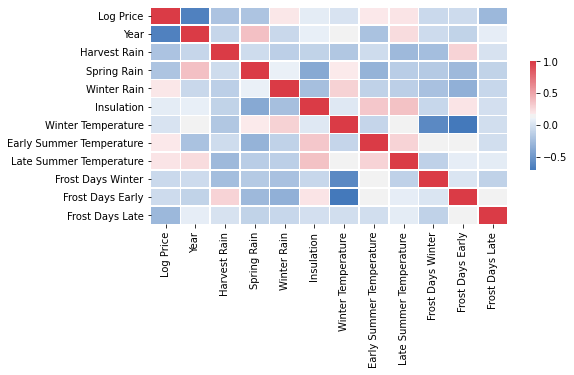

In [10]:
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)

corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

,Year,Harvest Rain,Spring Rain,Winter Rain,Insulation,Winter Temperature,Early Summer Temperature,Late Summer Temperature,Frost Days Winter,Frost Days Early,Frost Days Late
1950,-0.038585,-0.104081,0.022945,0.060024,0.033843,-0.238500,-0.022735,0.262367,-0.183712,-0.140550,-0.093955
1951,-0.028489,-0.109636,-0.053458,0.066280,-0.009598,-0.368545,0.110483,0.229034,-0.328974,-0.243503,-0.121279
1952,-0.029445,-0.104062,-0.061654,0.056252,-0.000412,-0.347064,0.085493,0.224079,-0.305950,-0.244386,-0.115888
1953,-0.033407,-0.121511,-0.052552,0.068574,-0.056885,-0.210702,0.193448,0.172585,-0.223266,-0.159466,-0.092662
1954,-0.030089,-0.120510,-0.043692,0.032726,-0.023935,-0.268261,0.176539,0.156530,-0.288560,-0.206564,-0.095966


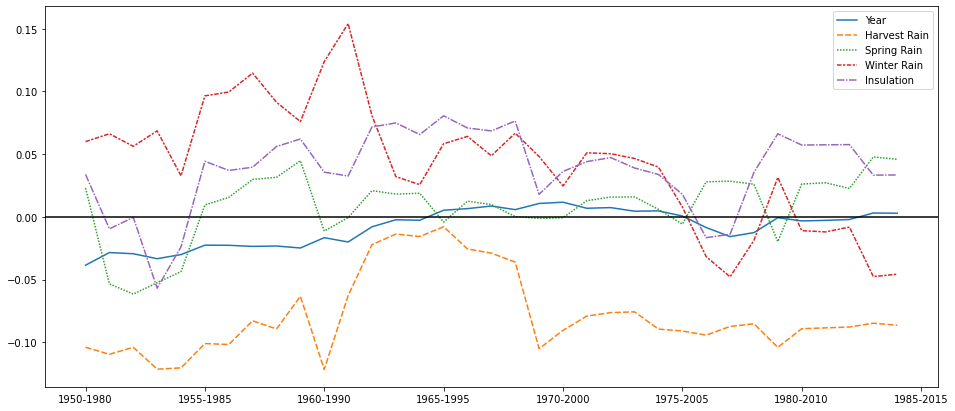

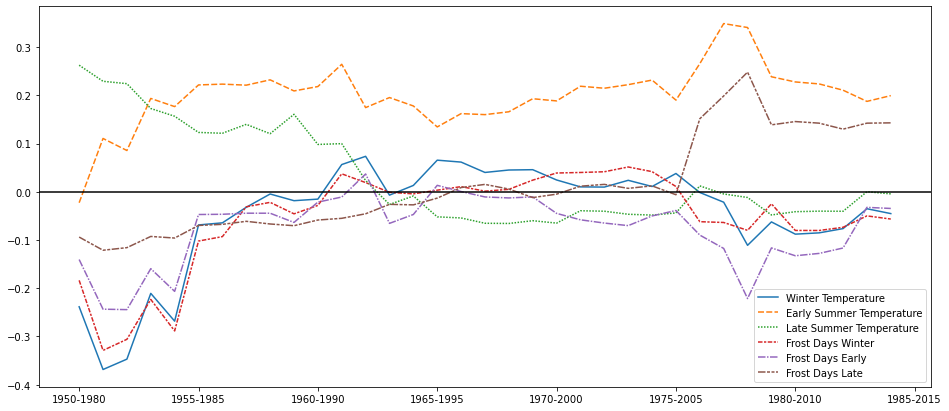

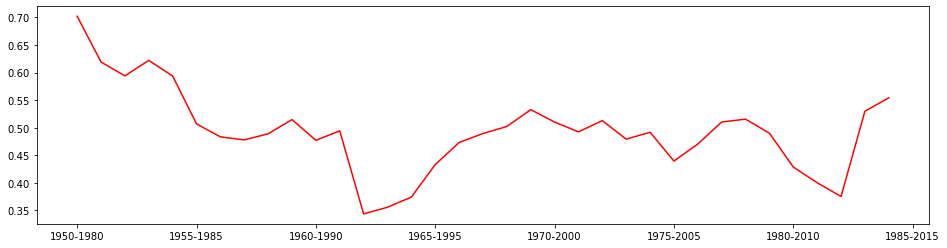

Average score over the whole period:  0.49364962443995686


In [11]:
coefficients, scores = model_tester(X,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,36,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

This is better, but there is too many features: 11 features for predicting a 30 dimensional vector.
Let us rank the features according to their average importance.

In [12]:
from sklearn.metrics import r2_score

display(y)
for column in X.columns:
    print(r2_score(y.loc[1950:2015, 'Log Price'].values, X.loc[1950:2015, column].values))

,Log Price
Vintage,
1950,6.478290
1951,6.679180
1952,5.828105
1953,6.934953
1954,6.716249
...,...
2015,6.607551
2016,6.495517
2017,6.067268


-676255.713100154
-120826.95993788664
-1775956.5879682219
-25337724.19371331
-17477.80122602098
-95710.08815185259
-30125.585043739866
-1599.1101432006556
-514.9472165289754
-182.50799703763914


# Improved model

In [18]:
X = pd.DataFrame(index = precipitations.index)

X['Winter Rain'] =  precipitations.shift(1)['Dec'] # really important


X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2



X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])


X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2


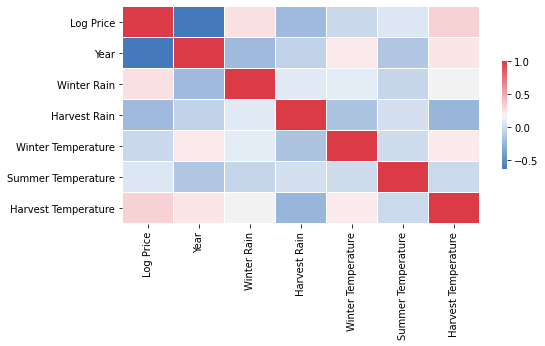

In [21]:
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)

corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.savefig('views/heatmap.png', bbox_inches='tight')
plt.show()

,Year,Winter Rain,Harvest Rain,Winter Temperature,Summer Temperature,Harvest Temperature
1950,-0.039967,0.011509,-0.078629,0.011944,-0.016269,0.326344
1951,-0.032868,0.118291,-0.074808,0.033449,0.063166,0.296062
1952,-0.031995,0.111790,-0.078468,0.034865,0.061875,0.297823
1953,-0.033073,0.115789,-0.093286,0.031831,0.113320,0.234525
1954,-0.031349,0.101415,-0.088785,0.033441,0.114170,0.247649


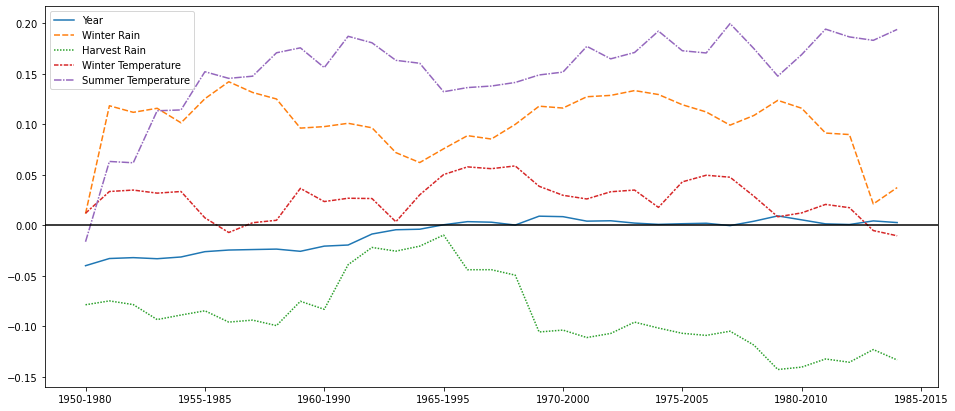

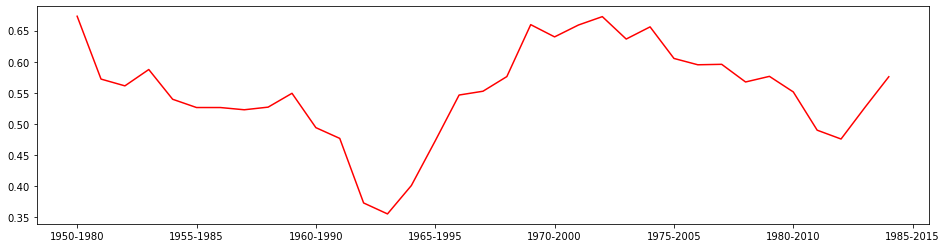

Average score over the whole period:  0.551927370357947


In [14]:
coefficients, scores = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.xticks(range(1950,1986,5),labels=labels)
plt.show()

plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,36,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

# Can it predict prices?

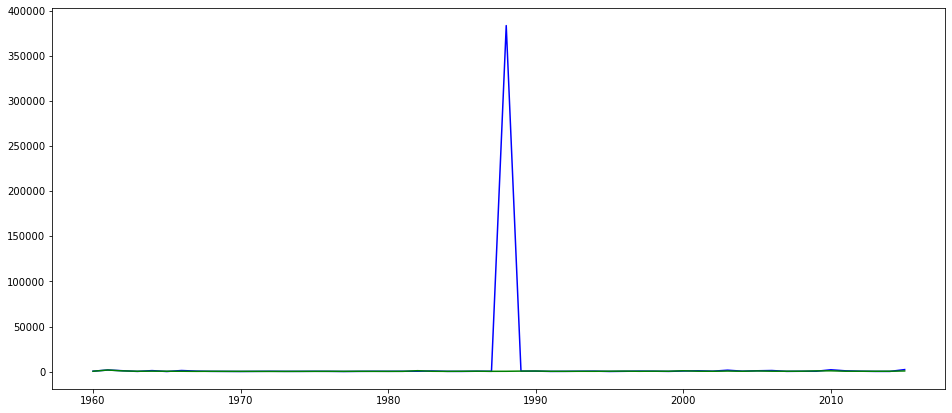

In [15]:
def reg_predict(X,y, window_length):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1985))
    predictions = []

    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for target_vintage in range(1950+window_length,2016):
        oldest_vintage = target_vintage - window_length
        newest_vintage = target_vintage

        y_ex = y.loc[oldest_vintage:newest_vintage-1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage-1,:].reset_index()
        model.fit(X_ex,y_ex)

        target = np.array([target_vintage]+X.loc[target_vintage,:].to_list()).reshape(1,-1)
        prediction = model.predict(target)
        predictions.append(prediction)
    return predictions
    
window_length = 10
plt.figure(figsize=(16,7))
plt.plot(range(1950+window_length,2016), np.exp(reg_predict(X,y, window_length)), color='blue')
sns.lineplot(data=np.exp(y.loc[1950+window_length:2015,'Log Price']), color='green')
plt.show()

Let us compare the r2 score of our model, regression with a window of width n against the r2 score of a simple model that draws a regression line on the last n prices and simply continues that line to predict the next price.

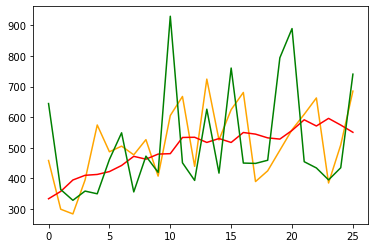

[-1.3725273540761918, -0.5240971856413053, -0.4592277307820185, -0.23243608721399056, -0.15744549694180843, -0.322964198216366, -0.1469170215095459, -0.10356614502756845, 0.01762381519109757, 0.06315266527624896, 0.019836429308044634, 0.09772070911877251, 0.05929791526530048, 0.04375744118246072, 0.0017910696052396702, -0.0035355785634356707, 0.07026723710640859, 0.1343069757246409, 0.11317634690956424, 0.1070400634585249, 0.14067756012495414, 0.16999619522837395, 0.11346141074397931, 0.10303804944458761, 0.06490253045590644, 0.05464167772884121, 0.03507860566570742, 0.04599823757084143]


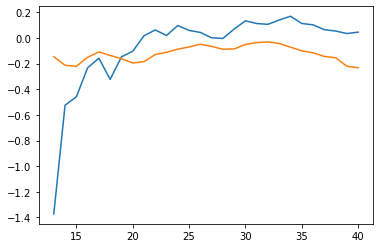

Maximal score:  0.16999619522837395


In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

scores=[]
other_scores=[]
line_regressor = LinearRegression()

for window_length in range(13,41,1):
    prediction = np.exp(reg_predict(X,y, window_length))
    prediction = np.array(prediction.reshape(1,-1).tolist()[0][-26:]).reshape(1,-1)[0]
    actual_prices = np.exp(y.loc[1990:2015,'Log Price']).values

    line_model_predictions = np.zeros_like(actual_prices)
    
    for vintage in range(1990,2016):
        X_ex = np.array(X.loc[(vintage - window_length):(vintage -1)].index.to_list()).reshape(-1,1)
        y_ex = y.loc[(vintage - window_length):(vintage -1),'Log Price']
        line_regressor.fit(X_ex, y_ex)
        target = np.array([vintage]).reshape(1,-1)
        line_model_predictions[vintage-1990] = line_regressor.predict(target)

    line_model_predictions = np.exp(line_model_predictions)
    if window_length==30:
        plt.plot(prediction, color='orange')
        plt.plot(line_model_predictions, color='red')
        plt.plot(actual_prices, color='green')
        plt.show()
    scores.append(r2_score(actual_prices, prediction))
    other_scores.append(r2_score(actual_prices, line_model_predictions))

print(scores)
plt.plot(range(13,41,1),scores)
plt.plot(range(13,41,1),other_scores)

plt.show()
print('Maximal score: ',max(scores))

According to the results, let us keep a window length of 30.
Now, try to quantify the predictive performance of this algo across the last 50 years.

36


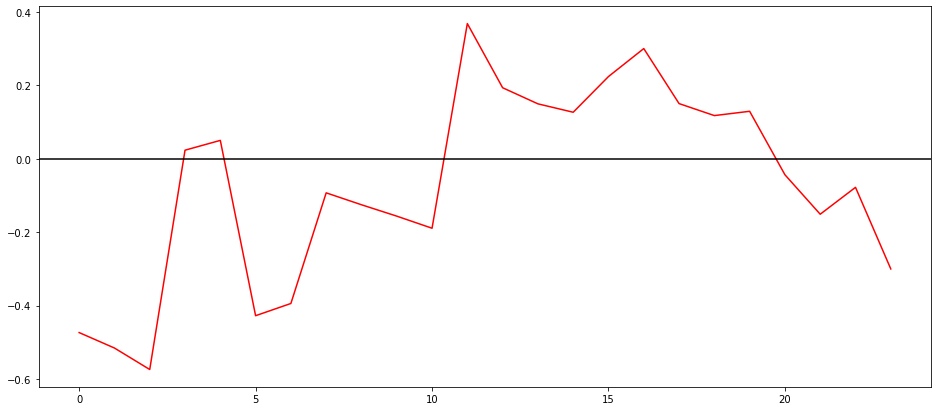

36 -0.053556638987841465


In [17]:
window_length=30

predictions = np.exp(reg_predict(X,y, window_length))
actual_prices = np.exp(y.loc[1980:2015,'Log Price']).values
print(len(predictions))
r2_scores=[]
for i in range(24):
    r2_scores.append(r2_score(actual_prices[i:(i+10)],predictions[i:(i+10)]))

plt.figure(figsize=(16,7))
sns.lineplot(x=range(24), y=r2_scores, color='red').axhline(0., color='black')
plt.show()

print(len(predictions), r2_score(actual_prices, predictions))

# Appendix: Trying PCA

In [ ]:
X = pd.concat([precipitations, insulation, temp_maximals, temp_minimals, frost_days], axis=1)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()
print(pca.components_)

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)

In [ ]:
coefficients, scores = model_tester(X2,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.show()
print('Average score over the whole period: ',np.mean(scores))

PCA doesn't give good enough results, provided that it makes us lose track of the variables' meanings. We will not use it.